<a href="https://colab.research.google.com/github/PratikshitSingh/pytorch-tuts/blob/main/adversarial_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/My Drive/CS444/Extra/')

# Fast Gradient Sign Attack

In [3]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from time import sleep

### Different epsilons to be used to perturb images for adversarial attack

In [4]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

##Model Under Attack

In [5]:
from torchvision.models import resnet18, ResNet18_Weights

In [6]:
# New weights with accuracy 80.858%
resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 373MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Initialize the Weight Transforms
weights     = ResNet18_Weights.IMAGENET1K_V1
preprocess  = weights.transforms()

In [8]:
# Initialize model
weights = ResNet18_Weights.IMAGENET1K_V1
model   = resnet18(weights=weights)

num_ftrs  = model.fc.in_features
model.fc  = nn.Linear(num_ftrs, 10)

In [9]:
# Define what device we are using
use_cuda = True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = model.to(device)

CUDA Available:  True


In [10]:
# unzip the .tgz dataset file
#!tar -xzvf 'imagenette2-320.tgz'

In [11]:
# Dataloader for imagenette2-320

class Imagenette2DataLoader(torch.utils.data.DataLoader):
    def __init__(self, root_dir, batch_size, num_workers=4, shuffle=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            batch_size (int): Number of images in each batch.
            num_workers (int): Number of subprocesses to use for data loading.
            shuffle (bool): Set to True to have the data reshuffled at every epoch.
        """
        self.root_dir     = root_dir
        self.batch_size   = batch_size
        self.num_workers  = num_workers
        self.shuffle      = shuffle
        
        # Define the data transforms
        self.transform = transforms.Compose([
            transforms.Resize(320),
            transforms.CenterCrop(320),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
        # Load the dataset
        self.dataset = ImageFolder(root=self.root_dir, transform=self.transform)
        
        # Initialize the PyTorch DataLoader
        super().__init__(dataset=self.dataset, batch_size=self.batch_size,
                         shuffle=self.shuffle, num_workers=self.num_workers)


In [27]:
train_loader = Imagenette2DataLoader(root_dir='./imagenette2-320/train', batch_size=16, num_workers=2, shuffle=True)
test_loader = Imagenette2DataLoader(root_dir='./imagenette2-320/val', batch_size=1, num_workers=2, shuffle=True)

In [13]:
print('Number of batches in train dataloader =', len(train_loader))
print('Number of batches in test dataloader =', len(test_loader))

Number of batches in train dataloader = 592
Number of batches in test dataloader = 246


In [14]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [15]:
# Fine-tuning the RessNet50 model with the CrossEntropyLoss.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr):

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, data_pair in enumerate(tqdm(train_loader)):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device
            images, labels = data_pair
            images, labels = images.to(device), labels.to(device)
  
            optimizer.zero_grad()
      
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            # TODO: Get predicted results
            predicted = torch.argmax(outputs, axis =1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

    print('Finished Training')

In [16]:
criterion   = nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(lr = 1e-3, params= model.parameters())

train(model, criterion, optimizer, num_epochs=5, decay_epochs=15, init_lr=0.001)

  0%|          | 0/592 [00:00<?, ?it/s]

[1,   100] loss: 1.194 acc: 63.31 time: 317.96
[1,   200] loss: 0.910 acc: 71.62 time: 305.16
[1,   300] loss: 0.796 acc: 74.56 time: 299.77
[1,   400] loss: 0.746 acc: 76.19 time: 303.31
[1,   500] loss: 0.682 acc: 78.56 time: 313.35


  0%|          | 0/592 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[2,   100] loss: 0.538 acc: 81.94 time: 12.95
[2,   200] loss: 0.513 acc: 84.38 time: 12.25
[2,   300] loss: 0.609 acc: 81.00 time: 11.98
[2,   400] loss: 0.529 acc: 83.25 time: 11.50
[2,   500] loss: 0.498 acc: 84.81 time: 12.19


  0%|          | 0/592 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():Exception ignored 

[3,   100] loss: 0.405 acc: 86.56 time: 13.28
[3,   200] loss: 0.370 acc: 88.06 time: 12.24
[3,   300] loss: 0.381 acc: 88.50 time: 12.40
[3,   400] loss: 0.369 acc: 88.19 time: 11.48
[3,   500] loss: 0.435 acc: 86.44 time: 12.14


  0%|          | 0/592 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():Exception ignored 

[4,   100] loss: 0.278 acc: 90.94 time: 13.35
[4,   200] loss: 0.305 acc: 89.38 time: 12.56
[4,   300] loss: 0.358 acc: 88.25 time: 12.31
[4,   400] loss: 0.380 acc: 88.25 time: 11.74
[4,   500] loss: 0.328 acc: 89.88 time: 12.06


  0%|          | 0/592 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    : if w.is_alive():
can only test a child process  File "/usr/lib/p

[5,   100] loss: 0.226 acc: 92.88 time: 14.87
[5,   200] loss: 0.315 acc: 90.38 time: 15.98
[5,   300] loss: 0.302 acc: 90.50 time: 12.50
[5,   400] loss: 0.230 acc: 92.38 time: 12.40
[5,   500] loss: 0.306 acc: 89.69 time: 12.37
Finished Training


In [18]:
torch.save(model.state_dict(), './Resnet_10_class')

## FGSM Attack

In [19]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Testing Function

In [20]:
import pdb

In [29]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for i, data_pair in enumerate(tqdm(test_loader)):
        sleep(0.01)

        data, target  = data_pair

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        init_pred = init_pred.squeeze()

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### Run the attack

In [30]:
torch.cuda.empty_cache()

In [31]:
import gc
gc.collect()

389

In [32]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 247092 KiB |   1627 MiB |  13179 GiB |  13179 GiB |\n|       from large pool | 220992 KiB |   1614 MiB |  13144 GiB |  13144 GiB |\n|       from small pool |  26100 KiB |     26 MiB |     35 GiB |     35 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 247092 KiB |   1627 MiB |  13179 GiB |  13179 GiB |\n|       from large pool | 220992 KiB |   1614 MiB |

In [33]:
accuracies = []
examples = []

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

# Run test for each epsilon
for eps in epsilons:
    print('Value of epsilon = ', eps)
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Value of epsilon =  0


  0%|          | 0/3925 [00:00<?, ?it/s]

Epsilon: 0	Test Accuracy = 2231 / 3925 = 0.5684076433121019
Value of epsilon =  0.05


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.05	Test Accuracy = 1572 / 3925 = 0.4005095541401274
Value of epsilon =  0.1


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
AssertionError:     self._shutdown_workers()can only test a child process
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    Exception ignored in: if w.is_aliv

Epsilon: 0.1	Test Accuracy = 1201 / 3925 = 0.3059872611464968
Value of epsilon =  0.15


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200><function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/tor

Epsilon: 0.15	Test Accuracy = 974 / 3925 = 0.24815286624203822
Value of epsilon =  0.2


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.2	Test Accuracy = 820 / 3925 = 0.2089171974522293
Value of epsilon =  0.25


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.25	Test Accuracy = 706 / 3925 = 0.17987261146496816
Value of epsilon =  0.3


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4d3752200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.3	Test Accuracy = 611 / 3925 = 0.15566878980891719


### Accuracy vs Epsilon

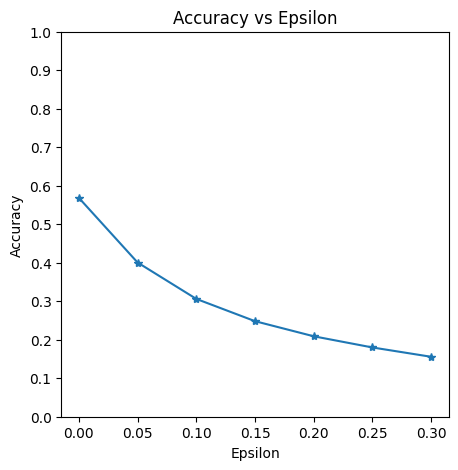

In [34]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()